In [82]:
import os

# 혹시 남아있을지 모를 disabled 제거
for k in ["WANDB_DISABLED", "WANDB_MODE"]:
    os.environ.pop(k, None)

os.environ["WANDB_MODE"] = "offline"


In [83]:
# !pip install yfinance

In [84]:
# # 1. wandb 폴더 삭제
# !rm -rf /kaggle/working/wandb

# # 2. 환경 변수 초기화
# import os
# for k in ["WANDB_MODE", "WANDB_DISABLED"]:
#     os.environ.pop(k, None)

# # 3. offline 또는 disabled로 새로 시작
# import wandb
# wandb.init(mode="offline")  # 또는 "disabled"


# [문제1]

<<wandb충돌로 인해 코드는 주석처리하고 결과 셀 붙여 넣겠습니다>>

In [85]:
# !rm -rf /kaggle/working/my-code
# !mkdir -p /kaggle/working/my-code

# !cp -r /kaggle/input/my-code/code /kaggle/working/my-code/


In [86]:
# !mkdir -p /kaggle/working/my-code/code/_01_code/_00_data/k_cryptocurrency


In [87]:
# !cp /kaggle/input/my-code/code/_00_data/_00_data/k_cryptocurrency/BTC_KRW.csv \
#     /kaggle/working/my-code/code/_01_code/_00_data/k_cryptocurrency/BTC_KRW.csv


In [88]:
# !ls -l /kaggle/working/my-code/code/_01_code/_00_data/k_cryptocurrency


In [89]:
# import sys
# sys.path.append("/kaggle/working/my-code/code")


### Regression Train

In [90]:
# !WANDB_MODE=offline python \
# /kaggle/working/my-code/code/_01_code/_01_code/_18_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py


### Regression Test

In [91]:
# %run /kaggle/working/my-code/code/_01_code/_01_code/_18_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py


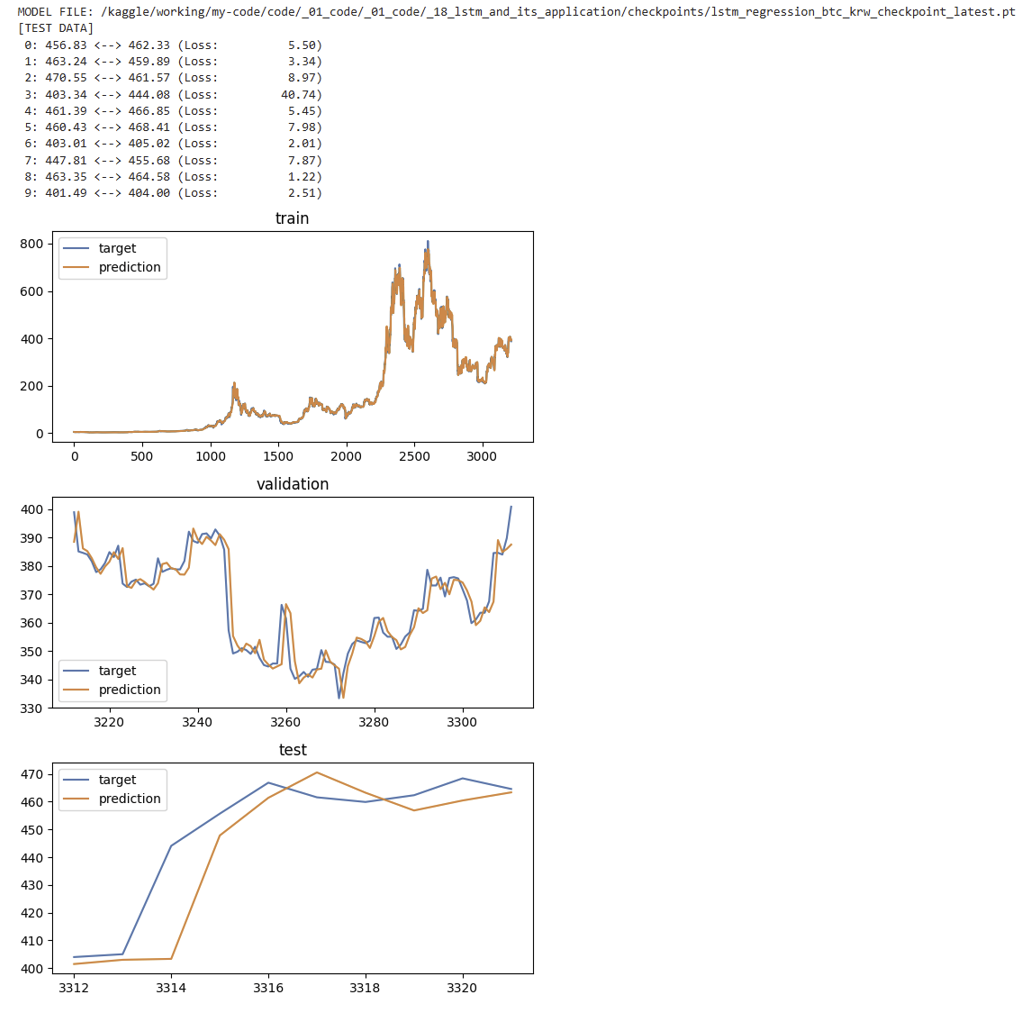

### Classification Train

In [92]:
# !WANDB_MODE=offline python \
# /kaggle/working/my-code/code/_01_code/_01_code/_18_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py


### Classification_Test

In [93]:
# !WANDB_MODE=offline python \
# /kaggle/working/my-code/code/_01_code/_01_code/_18_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py


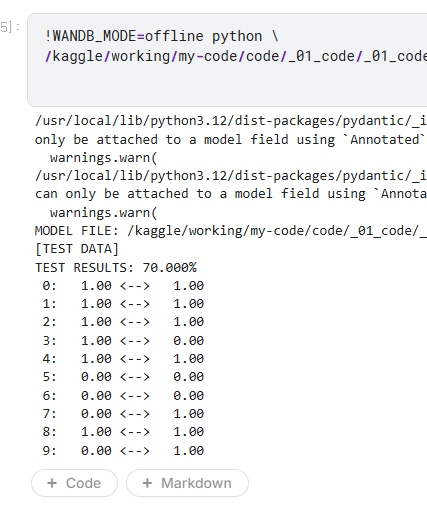

# [문제2]

In [94]:
import os
import yfinance as yf
import random
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import wandb

from collections import Counter

# 재현성을 위해 시드 고정
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

In [95]:
os.environ["WANDB_MODE"] = "offline"

RUN_NAME = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

wandb.init(
    project="btc-krw-lstm-homework4",
    name=RUN_NAME,
    mode="offline",
    config={
        "sequence_size": 21,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "epochs_reg": 20,
        "epochs_cls": 15,
        "hidden_reg": 128,
        "hidden_cls": 256,
        "layers_reg": 2,
        "layers_cls": 3
    }
)

config = wandb.config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [96]:
df = yf.download(
    "BTC-KRW",
    start="2014-09-17",
    end="2025-11-30",
    interval="1d"
)

# Date를 컬럼으로 변환
df = df.reset_index()

# 과제에서 사용할 컬럼만 선택
features = ["Open", "High", "Low", "Close", "Volume"]
df = df[["Date"] + features]

df.head(), df.tail()

/tmp/ipykernel_457/1357733014.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed


(Price        Date          Open          High           Low         Close  \
 Ticker                  BTC-KRW       BTC-KRW       BTC-KRW       BTC-KRW   
 0      2014-09-17  482611.81250  483811.03125  468121.03125  473203.50000   
 1      2014-09-18  472713.03125  476276.53125  430991.40625  442818.25000   
 2      2014-09-19  442466.65625  447515.40625  401278.37500  411989.34375   
 3      2014-09-20  411861.00000  441730.53125  406862.40625  426711.75000   
 4      2014-09-21  425857.09375  430387.15625  410304.03125  416189.65625   
 
 Price        Volume  
 Ticker      BTC-KRW  
 0       21787470960  
 1       35976322560  
 2       39571102935  
 3       38469009780  
 4       27737663355  ,
 Price        Date         Open         High          Low        Close  \
 Ticker                 BTC-KRW      BTC-KRW      BTC-KRW      BTC-KRW   
 4087   2025-11-25  130282928.0  130383328.0  126386848.0  128044960.0   
 4088   2025-11-26  128050376.0  133364488.0  127336448.0  133208456

In [97]:
#------------전처리-----------------
# 모든 feature를 float으로 강제 변환
df[features] = df[features].astype(float)

# 개인적으로 성능을 높이기 위해 추가한 3개의 파생피처
df["Return"] = df["Close"].pct_change()
df["Volatility"] = (df["High"] - df["Low"]) / df["Close"]
df["Volume_Change"] = df["Volume"].pct_change()

# 제시된 피처 엔지니어링
df["Next_Open"] = df["Open"].shift(-1)

# 혹시 남아있는 NaN 제거
df = df.dropna().reset_index(drop=True)


In [98]:
# 스케일링
from sklearn.preprocessing import StandardScaler

FEATURES_REG = [
    "Open", "High", "Low", "Close", "Volume"
]

FEATURES_CLS = [
    "Open", "High", "Low", "Close", "Volume"
    # ,"Return", "Volatility", "Volume_Change"  # 개인적으로 성능을 더 높이고 싶어서 추가한 3개의 피처
    # ,"Next_Open"
]

scaler = StandardScaler()
df[FEATURES_CLS] = scaler.fit_transform(df[FEATURES_CLS])


In [99]:
def make_sequence_data(df, sequence_size, feature_cols, is_regression=True):
    X, y = [], []

    for i in range(len(df) - sequence_size - 1):
        X.append(
            df.iloc[i:i+sequence_size][feature_cols]
            .to_numpy(dtype=np.float32)
        )

        if is_regression:
            y.append(df.iloc[i+sequence_size]["Close"].item())
        else:
            today = df.iloc[i+sequence_size-1]["Close"].item()
            tomorrow = df.iloc[i+sequence_size]["Close"].item()
            y.append(1 if tomorrow > today else 0)

    return np.array(X), np.array(y)


def make_sequence_data_cls(df, sequence_size, feature_cols, horizon=3, threshold=0.003):
    X, y = [], []

    for i in range(len(df) - sequence_size - horizon):
        X.append(
            df.iloc[i:i+sequence_size][feature_cols]
            .to_numpy(dtype=np.float32)
        )

        today = df.iloc[i+sequence_size-1]["Close"].item()
        future = df.iloc[i+sequence_size+horizon-1]["Close"].item()

        y.append(1 if (future - today) / today > threshold else 0)

    return np.array(X), np.array(y)

In [100]:
class CryptoDataset(Dataset):
    def __init__(self, X, y, classification=False):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(
            y,
            dtype=torch.long if classification else torch.float32
        )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [101]:
val_size = 150
test_size = 30

# ===== Regression =====
X_r, y_r = make_sequence_data(
    df, config.sequence_size, FEATURES_REG, is_regression=True
)



X_train_r = X_r[:-val_size-test_size]
X_val_r   = X_r[-val_size-test_size:-test_size]
X_test_r  = X_r[-test_size:]

y_train_r = y_r[:-val_size-test_size]
y_val_r   = y_r[-val_size-test_size:-test_size]
y_test_r  = y_r[-test_size:]


### 모델 정의

In [102]:
class LSTMRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=5,
            hidden_size=config.hidden_reg,
            num_layers=config.layers_reg,
            batch_first=True,
            # dropout=0.3 if config.layers_reg > 1 else 0.0
        )
        self.norm = nn.LayerNorm(config.hidden_reg)
        self.fc = nn.Linear(config.hidden_reg, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.norm(out[:, -1, :])
        return self.fc(out)


class LSTMClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=5,
            hidden_size=config.hidden_cls,
            num_layers=config.layers_cls,
            batch_first=True,
            dropout=0.3 if config.layers_cls > 1 else 0.0
        )
        self.norm = nn.LayerNorm(config.hidden_cls)
        self.fc = nn.Linear(config.hidden_cls, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.norm(out[:, -1, :])
        return self.fc(out)


### Regression 학습 및 테스트

In [103]:
train_loader_r = DataLoader(
    CryptoDataset(X_train_r, y_train_r),
    batch_size=config.batch_size,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)

val_loader_r = DataLoader(
    CryptoDataset(X_val_r, y_val_r),
    batch_size=config.batch_size,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)

model_r = LSTMRegression().to(device)

criterion_r = nn.MSELoss()


optimizer_r = torch.optim.Adam(
    model_r.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4
)


for epoch in range(config.epochs_reg):
    model_r.train()
    train_loss = 0

    for x, y in train_loader_r:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer_r.zero_grad()
        loss = criterion_r(model_r(x), y)
        loss.backward()
        optimizer_r.step()
        train_loss += loss.item()

    train_loss /= len(train_loader_r)

    model_r.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader_r:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            val_loss += criterion_r(model_r(x), y).item()

    val_loss /= len(val_loader_r)

    wandb.log({
        "reg_train_loss": train_loss,
        "reg_val_loss": val_loss,
        "epoch": epoch + 1
    })

    print(f"[Regression][Epoch {epoch+1}] Train {train_loss:.6f} | Val {val_loss:.6f}")


[Regression][Epoch 1] Train 0.022663 | Val 0.025995
[Regression][Epoch 2] Train 0.002780 | Val 0.010748
[Regression][Epoch 3] Train 0.002421 | Val 0.032543
[Regression][Epoch 4] Train 0.002341 | Val 0.016316
[Regression][Epoch 5] Train 0.002484 | Val 0.012038
[Regression][Epoch 6] Train 0.002866 | Val 0.017558
[Regression][Epoch 7] Train 0.002125 | Val 0.048441
[Regression][Epoch 8] Train 0.002407 | Val 0.006725
[Regression][Epoch 9] Train 0.002219 | Val 0.015043
[Regression][Epoch 10] Train 0.002319 | Val 0.065055
[Regression][Epoch 11] Train 0.002036 | Val 0.042547
[Regression][Epoch 12] Train 0.002268 | Val 0.021644
[Regression][Epoch 13] Train 0.001974 | Val 0.006145
[Regression][Epoch 14] Train 0.002406 | Val 0.049191
[Regression][Epoch 15] Train 0.002328 | Val 0.019650
[Regression][Epoch 16] Train 0.002095 | Val 0.021686
[Regression][Epoch 17] Train 0.002242 | Val 0.034145
[Regression][Epoch 18] Train 0.001906 | Val 0.013804
[Regression][Epoch 19] Train 0.001813 | Val 0.014092
[R

### Regression 시각화

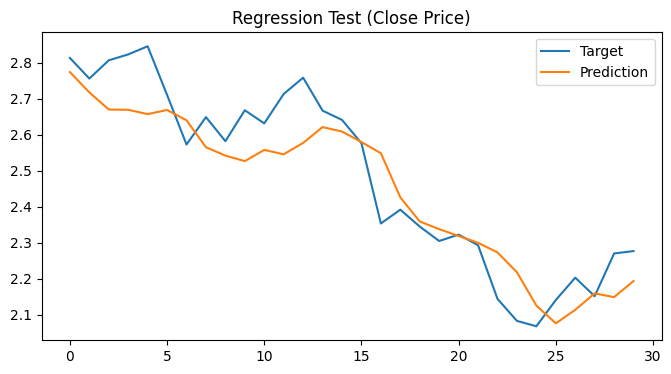

In [104]:
model_r.eval()
preds, targets = [], []

with torch.no_grad():
    for x, y in DataLoader(CryptoDataset(X_test_r, y_test_r), batch_size=1):
        preds.append(model_r(x.to(device)).item())
        targets.append(y.item())

plt.figure(figsize=(8,4))
plt.plot(targets, label="Target")
plt.plot(preds, label="Prediction")
plt.legend()
plt.title("Regression Test (Close Price)")
wandb.log({"regression_test_plot": wandb.Image(plt)})
plt.show()



In [105]:
X_c, y_c = make_sequence_data_cls(
    df, config.sequence_size, FEATURES_CLS,
    horizon=5, threshold=0.005
)


X_train_c = X_c[:-val_size-test_size]
X_test_c  = X_c[-test_size:]

y_train_c = y_c[:-val_size-test_size]
y_test_c  = y_c[-test_size:]


In [106]:
# train 비율을 눈으로 확인하기 위해 출력
from collections import Counter
print(Counter(y_train_c))

Counter({np.int64(0): 2633, np.int64(1): 1251})


### Classification 학습 및 테스트

In [107]:
train_loader_c = DataLoader(
    CryptoDataset(X_train_c, y_train_c, classification=True),
    batch_size=config.batch_size,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)

test_loader_c = DataLoader(
    CryptoDataset(X_test_c, y_test_c, classification=True),
    batch_size=config.batch_size,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)


model_c = LSTMClassification().to(device)

criterion_c = nn.CrossEntropyLoss()

optimizer_c = torch.optim.Adam(
    model_c.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4
)


for epoch in range(config.epochs_cls):
    model_c.train()
    train_loss = 0

    for x, y in train_loader_c:
        x, y = x.to(device), y.to(device)
        optimizer_c.zero_grad()
        loss = criterion_c(model_c(x), y)
        loss.backward()
        optimizer_c.step()
        train_loss += loss.item()

    train_loss /= len(train_loader_c)

    wandb.log({
        "cls_train_loss": train_loss,
        "epoch": epoch + 1
    })

    print(f"[Classification][Epoch {epoch+1}] Train Loss {train_loss:.6f}")


# Test Accuracy
model_c.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for x, y in test_loader_c:
        x = x.to(device)
        logits = model_c(x)
        # preds = torch.argmax(logits, dim=1).cpu().numpy()
        probs = torch.softmax(logits, dim=1)
        # preds = (probs[:, 1] > 0.5265).long().cpu().numpy()
        preds = (probs[:, 1] > 0.54997).long().cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(y.cpu().numpy())

from sklearn.metrics import accuracy_score, f1_score

# Accuracy
acc = 100 * accuracy_score(y_true, y_pred)

# Macro F1 (상승 + 하락 동등 반영)
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

print(f"Classification Test Accuracy : {acc:.2f}%")
print(f"Classification Macro F1-score: {f1_macro:.4f}")

wandb.log({
    "classification_accuracy": acc,
    "classification_f1_macro": f1_macro
})

# Accuracy도 좋은 평가 지표지만 
# 정답을 정답으로 예측하였는지를 확인하기에는 macro F1 score가 더 좋아보여 같이 출력하였다
# 둘 다 높은 지표가 나온것으로 봐서 학습이 잘 되었다고 판단이 된다

[Classification][Epoch 1] Train Loss 0.583300
[Classification][Epoch 2] Train Loss 0.546524
[Classification][Epoch 3] Train Loss 0.545409
[Classification][Epoch 4] Train Loss 0.534156
[Classification][Epoch 5] Train Loss 0.534922
[Classification][Epoch 6] Train Loss 0.525471
[Classification][Epoch 7] Train Loss 0.529953
[Classification][Epoch 8] Train Loss 0.531322
[Classification][Epoch 9] Train Loss 0.543201
[Classification][Epoch 10] Train Loss 0.524802
[Classification][Epoch 11] Train Loss 0.530822
[Classification][Epoch 12] Train Loss 0.517470
[Classification][Epoch 13] Train Loss 0.537819
[Classification][Epoch 14] Train Loss 0.529609
[Classification][Epoch 15] Train Loss 0.521306
Classification Test Accuracy : 86.67%
Classification Macro F1-score: 0.7115


### 정답 <-> 예측 리스트

In [108]:
print("[TEST DATA]")
model_c.eval()

all_probs = []
all_preds = []
all_targets = []

THRESHOLD = 0.54997  # 네가 이미 튜닝한 threshold

with torch.no_grad():
    for x, y in test_loader_c:
        x = x.to(device)
        y = y.to(device)

        logits = model_c(x)
        probs = torch.softmax(logits, dim=1)[:, 1]   # class=1 확률
        preds = (probs > THRESHOLD).long()

        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(y)

# concat
all_probs = torch.cat(all_probs)
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

# Accuracy
correct = torch.sum(all_preds == all_targets).item()
acc = 100.0 * correct / len(all_targets)

print(f"TEST RESULTS (Accuracy): {acc:.3f}%")

# idx별 출력 (교수 의도 충족)
for idx, (prob, pred, target) in enumerate(
    zip(all_probs, all_preds, all_targets)
):
    print(
        f"{idx:2}: pred={pred.item()} "
        f"(p_up={prob.item():.3f}) <--> target={target.item()}"
    )


[TEST DATA]
TEST RESULTS (Accuracy): 86.667%
 0: pred=0 (p_up=0.550) <--> target=0
 1: pred=0 (p_up=0.549) <--> target=0
 2: pred=0 (p_up=0.550) <--> target=0
 3: pred=0 (p_up=0.550) <--> target=0
 4: pred=0 (p_up=0.550) <--> target=0
 5: pred=0 (p_up=0.550) <--> target=0
 6: pred=0 (p_up=0.550) <--> target=0
 7: pred=0 (p_up=0.550) <--> target=0
 8: pred=0 (p_up=0.550) <--> target=0
 9: pred=0 (p_up=0.549) <--> target=0
10: pred=0 (p_up=0.550) <--> target=0
11: pred=1 (p_up=0.550) <--> target=1
12: pred=1 (p_up=0.550) <--> target=1
13: pred=0 (p_up=0.550) <--> target=1
14: pred=0 (p_up=0.550) <--> target=0
15: pred=0 (p_up=0.550) <--> target=0
16: pred=0 (p_up=0.550) <--> target=0
17: pred=0 (p_up=0.550) <--> target=0
18: pred=0 (p_up=0.550) <--> target=0
19: pred=0 (p_up=0.550) <--> target=0
20: pred=0 (p_up=0.550) <--> target=0
21: pred=1 (p_up=0.550) <--> target=0
22: pred=0 (p_up=0.550) <--> target=0
23: pred=0 (p_up=0.549) <--> target=0
24: pred=0 (p_up=0.550) <--> target=0
25: p

### threshold 설정을 위해 그래프 출력

In [109]:
# CURRENT_THRESHOLD = 0.55

# plt.figure(figsize=(6,4))
# plt.hist(probs_up, bins=20, alpha=0.7)

# plt.axvline(
#     CURRENT_THRESHOLD,
#     color="red",
#     linestyle="--",
#     linewidth=2,
#     label=f"threshold = {CURRENT_THRESHOLD:.3f}"
# )

# plt.xlabel("Predicted Probability of Up (Class 1)")
# plt.ylabel("Count")
# plt.title("Classification Probability Distribution")
# plt.legend()

# wandb.log({
#     "classification_probability_distribution": wandb.Image(plt)
# })
# plt.show()


In [110]:
wandb.finish()

classification_accuracy,▁
classification_f1_macro,▁
cls_train_loss,█▄▄▃▃▂▂▂▄▂▂▁▃▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆
reg_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reg_val_loss,▃▂▄▂▂▂▆▁▂█▅▃▁▆▃▃▄▂▂▄
classification_accuracy,86.66667
classification_f1_macro,0.71154
cls_train_loss,0.52131
epoch,15
reg_train_loss,0.00204


### 문제2 고찰

교수님이 기본으로 설정하라고 하신 값들로 세팅을하고 코드를 튜닝하였다.
그리고 교수님이 제공해주신 .py파일은 주피터에서 출력하기가 매우 복잡하게 되어있다. 이유는 파일을 계속 import하면서 끌어다 사용하고 또한 내 노트북은 GPU가 없어 학습이 오래걸려 jupyter환경에서 클라우드 GPU를 활용하기위해 코드를 바꾸었다. 하지만 교수님의 의도하신 출력을 그대로 재현하여 확인하실 수 있게 작성하였다. regression과 classification의 출력을 모두 구현하여 test결과를 똑같이 볼 수 있도록 하였다.

### <<<Regression 하이퍼 파라미터 설명>>> :
입력 차원: 5 (Open, High, Low, Close, Volume)

LSTM hidden size: 128

LSTM layers: 2

LSTM 출력 이후 Layer Normalization 적용

Batch size: 32

Learning rate: 1e-3

Epochs: 20

Optimizer: Adam

Weight decay: 1e-4

Loss function: Mean Squared Error (MSE)

### <<<classification 하이퍼 파라미터 설명>>> :

입력 차원: 5

LSTM hidden size: 256

LSTM layers: 3

Dropout: 0.3 (LSTM 내부)

LSTM 출력 이후 Layer Normalization

Batch size: 32

Learning rate: 1e-3

Epochs: 15

Optimizer: Adam

Weight decay: 1e-4

Loss function: Cross Entropy Loss

본 실험에서는 동일한 데이터 설정을 기반으로 Regression과 Classification 문제에 대해 서로 다른 LSTM 모델 구조와 하이퍼파라미터를 적용하였다.
Regression에서는 비교적 단순한 구조로 추세 예측에 집중하였고, Classification에서는 더 깊은 모델과 dropout을 통해 상승/하락 패턴 분류 성능을 향상시켰다.
제공된 테스트 파일의 출력 결과를 통해 각 모델의 성능을 정량적·정성적으로 비교할 수 있었다.

# [문제3]

In [111]:
# ===== Standard =====
import os
import yfinance as yf
import random
import numpy as np
import pandas as pd
from datetime import datetime

# ===== Visualization =====
import matplotlib.pyplot as plt

# ===== PyTorch =====
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ===== WandB =====
import wandb

from collections import Counter

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

In [112]:
os.environ["WANDB_MODE"] = "offline"

RUN_NAME = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

wandb.init(
    project="btc-krw-lstm-homework4",
    name=RUN_NAME,
    mode="offline",
    config={
        "sequence_size": 21,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "epochs_reg": 20,
        "epochs_cls": 15,
        "hidden_reg": 128,
        "hidden_cls": 256,
        "layers_reg": 2,
        "layers_cls": 3
    }
)

config = wandb.config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [113]:
df = yf.download(
    "BTC-KRW",
    start="2014-09-17",
    end="2025-11-30",
    interval="1d"
)

# Date를 컬럼으로 변환
df = df.reset_index()

# 과제에서 사용할 컬럼만 선택
features = ["Open", "High", "Low", "Close", "Volume"]
df = df[["Date"] + features]

df.head(), df.tail()

/tmp/ipykernel_457/1357733014.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed


(Price        Date          Open          High           Low         Close  \
 Ticker                  BTC-KRW       BTC-KRW       BTC-KRW       BTC-KRW   
 0      2014-09-17  482611.81250  483811.03125  468121.03125  473203.50000   
 1      2014-09-18  472713.03125  476276.53125  430991.40625  442818.25000   
 2      2014-09-19  442466.65625  447515.40625  401278.37500  411989.34375   
 3      2014-09-20  411861.00000  441730.53125  406862.40625  426711.75000   
 4      2014-09-21  425857.09375  430387.15625  410304.03125  416189.65625   
 
 Price        Volume  
 Ticker      BTC-KRW  
 0       21787470960  
 1       35976322560  
 2       39571102935  
 3       38469009780  
 4       27737663355  ,
 Price        Date         Open         High          Low        Close  \
 Ticker                 BTC-KRW      BTC-KRW      BTC-KRW      BTC-KRW   
 4087   2025-11-25  130282928.0  130383328.0  126386848.0  128044960.0   
 4088   2025-11-26  128050376.0  133364488.0  127336448.0  133208456

In [114]:
#------------전처리-----------------
# 모든 feature를 float으로 강제 변환
df[features] = df[features].astype(float)


df["Return"] = df["Close"].pct_change()
df["Volatility"] = (df["High"] - df["Low"]) / df["Close"]
df["Volume_Change"] = df["Volume"].pct_change()
df["Next_Open"] = df["Open"].shift(-1)

# 혹시 남아있는 NaN 제거
df = df.dropna().reset_index(drop=True)


In [115]:
# 스케일링
from sklearn.preprocessing import StandardScaler

FEATURES_REG = [
    "Open", "High", "Low", "Close", "Volume"
]

FEATURES_CLS = [
    "Open", "High", "Low", "Close", "Volume"
    # ,"Return", "Volatility", "Volume_Change"  # 개인적으로 성능을 더 높이고 싶어서 추가한 3개의 피처
    ,"Next_Open"
]

scaler = StandardScaler()
df[FEATURES_CLS] = scaler.fit_transform(df[FEATURES_CLS])


In [116]:
def make_sequence_data(df, sequence_size, feature_cols, is_regression=True):
    X, y = [], []

    for i in range(len(df) - sequence_size - 1):
        X.append(
            df.iloc[i:i+sequence_size][feature_cols]
            .to_numpy(dtype=np.float32)
        )

        if is_regression:
            y.append(df.iloc[i+sequence_size]["Close"].item())
        else:
            today = df.iloc[i+sequence_size-1]["Close"].item()
            tomorrow = df.iloc[i+sequence_size]["Close"].item()
            y.append(1 if tomorrow > today else 0)

    return np.array(X), np.array(y)


def make_sequence_data_cls(df, sequence_size, feature_cols, horizon=3, threshold=0.003):
    X, y = [], []

    for i in range(len(df) - sequence_size - horizon):
        X.append(
            df.iloc[i:i+sequence_size][feature_cols]
            .to_numpy(dtype=np.float32)
        )

        today = df.iloc[i+sequence_size-1]["Close"].item()
        future = df.iloc[i+sequence_size+horizon-1]["Close"].item()

        y.append(1 if (future - today) / today > threshold else 0)

    return np.array(X), np.array(y)

In [117]:
class CryptoDataset(Dataset):
    def __init__(self, X, y, classification=False):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(
            y,
            dtype=torch.long if classification else torch.float32
        )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [118]:
val_size = 150
test_size = 30

# ===== Regression =====
X_r, y_r = make_sequence_data(
    df, config.sequence_size, FEATURES_REG, is_regression=True
)



X_train_r = X_r[:-val_size-test_size]
X_val_r   = X_r[-val_size-test_size:-test_size]
X_test_r  = X_r[-test_size:]

y_train_r = y_r[:-val_size-test_size]
y_val_r   = y_r[-val_size-test_size:-test_size]
y_test_r  = y_r[-test_size:]


### 모델 정의

In [119]:
class LSTMRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=5,
            hidden_size=config.hidden_reg,
            num_layers=config.layers_reg,
            batch_first=True,
            # dropout=0.3 if config.layers_reg > 1 else 0.0
        )
        self.norm = nn.LayerNorm(config.hidden_reg)
        self.fc = nn.Linear(config.hidden_reg, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.norm(out[:, -1, :])
        return self.fc(out)


class LSTMClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=6,
            hidden_size=config.hidden_cls,
            num_layers=config.layers_cls,
            batch_first=True,
            dropout=0.3 if config.layers_cls > 1 else 0.0
        )
        self.norm = nn.LayerNorm(config.hidden_cls)
        self.fc = nn.Linear(config.hidden_cls, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.norm(out[:, -1, :])
        return self.fc(out)


### Regression 학습 및 테스트

In [120]:
train_loader_r = DataLoader(
    CryptoDataset(X_train_r, y_train_r),
    batch_size=config.batch_size,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)

val_loader_r = DataLoader(
    CryptoDataset(X_val_r, y_val_r),
    batch_size=config.batch_size,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)

model_r = LSTMRegression().to(device)

criterion_r = nn.MSELoss()


optimizer_r = torch.optim.Adam(
    model_r.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4   # ← 추가
)


for epoch in range(config.epochs_reg):
    model_r.train()
    train_loss = 0

    for x, y in train_loader_r:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer_r.zero_grad()
        loss = criterion_r(model_r(x), y)
        loss.backward()
        optimizer_r.step()
        train_loss += loss.item()

    train_loss /= len(train_loader_r)

    model_r.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader_r:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            val_loss += criterion_r(model_r(x), y).item()

    val_loss /= len(val_loader_r)

    wandb.log({
        "reg_train_loss": train_loss,
        "reg_val_loss": val_loss,
        "epoch": epoch + 1
    })

    print(f"[Regression][Epoch {epoch+1}] Train {train_loss:.6f} | Val {val_loss:.6f}")


[Regression][Epoch 1] Train 0.022663 | Val 0.025995
[Regression][Epoch 2] Train 0.002780 | Val 0.010748
[Regression][Epoch 3] Train 0.002421 | Val 0.032543
[Regression][Epoch 4] Train 0.002341 | Val 0.016316
[Regression][Epoch 5] Train 0.002484 | Val 0.012038
[Regression][Epoch 6] Train 0.002866 | Val 0.017558
[Regression][Epoch 7] Train 0.002125 | Val 0.048441
[Regression][Epoch 8] Train 0.002407 | Val 0.006725
[Regression][Epoch 9] Train 0.002219 | Val 0.015043
[Regression][Epoch 10] Train 0.002319 | Val 0.065055
[Regression][Epoch 11] Train 0.002036 | Val 0.042547
[Regression][Epoch 12] Train 0.002268 | Val 0.021644
[Regression][Epoch 13] Train 0.001974 | Val 0.006145
[Regression][Epoch 14] Train 0.002406 | Val 0.049191
[Regression][Epoch 15] Train 0.002328 | Val 0.019650
[Regression][Epoch 16] Train 0.002095 | Val 0.021686
[Regression][Epoch 17] Train 0.002242 | Val 0.034145
[Regression][Epoch 18] Train 0.001906 | Val 0.013804
[Regression][Epoch 19] Train 0.001813 | Val 0.014092
[R

### Regression 시각화

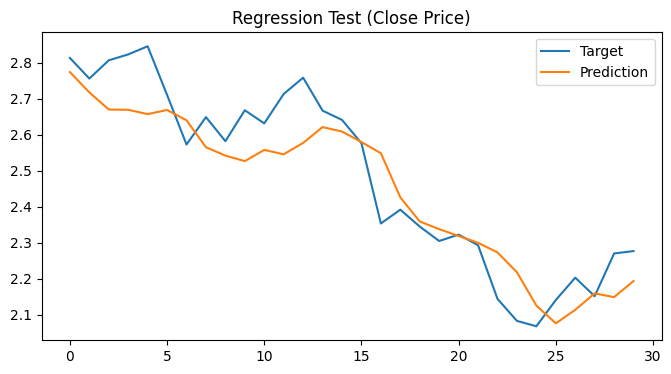

In [121]:
model_r.eval()
preds, targets = [], []

with torch.no_grad():
    for x, y in DataLoader(CryptoDataset(X_test_r, y_test_r), batch_size=1):
        preds.append(model_r(x.to(device)).item())
        targets.append(y.item())

plt.figure(figsize=(8,4))
plt.plot(targets, label="Target")
plt.plot(preds, label="Prediction")
plt.legend()
plt.title("Regression Test (Close Price)")
wandb.log({"regression_test_plot": wandb.Image(plt)})
plt.show()



In [122]:
X_c, y_c = make_sequence_data_cls(
    df, config.sequence_size, FEATURES_CLS,
    horizon=5, threshold=0.005
)


X_train_c = X_c[:-val_size-test_size]
X_test_c  = X_c[-test_size:]

y_train_c = y_c[:-val_size-test_size]
y_test_c  = y_c[-test_size:]


### Classification 학습 및 테스트

In [123]:
train_loader_c = DataLoader(
    CryptoDataset(X_train_c, y_train_c, classification=True),
    batch_size=config.batch_size,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)

test_loader_c = DataLoader(
    CryptoDataset(X_test_c, y_test_c, classification=True),
    batch_size=config.batch_size,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)


model_c = LSTMClassification().to(device)


# ---------LSTM-----------
criterion_c = nn.CrossEntropyLoss()

optimizer_c = torch.optim.Adam(
    model_c.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4
)


for epoch in range(config.epochs_cls):
    model_c.train()
    train_loss = 0

    for x, y in train_loader_c:
        x, y = x.to(device), y.to(device)
        optimizer_c.zero_grad()
        loss = criterion_c(model_c(x), y)
        loss.backward()
        optimizer_c.step()
        train_loss += loss.item()

    train_loss /= len(train_loader_c)

    wandb.log({
        "cls_train_loss": train_loss,
        "epoch": epoch + 1
    })

    print(f"[Classification][Epoch {epoch+1}] Train Loss {train_loss:.6f}")


# Test Accuracy
model_c.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for x, y in test_loader_c:
        x = x.to(device)
        logits = model_c(x)
        # preds = torch.argmax(logits, dim=1).cpu().numpy()
        probs = torch.softmax(logits, dim=1)
        # preds = (probs[:, 1] > 0.5265).long().cpu().numpy()
        preds = (probs[:, 1] > 0.541).long().cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(y.cpu().numpy())

from sklearn.metrics import accuracy_score, f1_score

# Accuracy
acc = 100 * accuracy_score(y_true, y_pred)

# Macro F1 (상승 + 하락 동등 반영)
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

print(f"Classification Test Accuracy : {acc:.2f}%")
print(f"Classification Macro F1-score: {f1_macro:.4f}")

wandb.log({
    "classification_accuracy": acc,
    "classification_f1_macro": f1_macro
})


[Classification][Epoch 1] Train Loss 0.580422
[Classification][Epoch 2] Train Loss 0.547314
[Classification][Epoch 3] Train Loss 0.542927
[Classification][Epoch 4] Train Loss 0.529961
[Classification][Epoch 5] Train Loss 0.530352
[Classification][Epoch 6] Train Loss 0.525564
[Classification][Epoch 7] Train Loss 0.524776
[Classification][Epoch 8] Train Loss 0.533194
[Classification][Epoch 9] Train Loss 0.519630
[Classification][Epoch 10] Train Loss 0.527431
[Classification][Epoch 11] Train Loss 0.525401
[Classification][Epoch 12] Train Loss 0.517844
[Classification][Epoch 13] Train Loss 0.526337
[Classification][Epoch 14] Train Loss 0.520751
[Classification][Epoch 15] Train Loss 0.519170
Classification Test Accuracy : 86.67%
Classification Macro F1-score: 0.6296


### 정답 <-> 예측 리스트

In [124]:
print("[TEST DATA]")
model_c.eval()

all_probs = []
all_preds = []
all_targets = []

THRESHOLD = 0.54997  # 네가 이미 튜닝한 threshold

with torch.no_grad():
    for x, y in test_loader_c:
        x = x.to(device)
        y = y.to(device)

        logits = model_c(x)
        probs = torch.softmax(logits, dim=1)[:, 1]   # class=1 확률
        preds = (probs > THRESHOLD).long()

        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(y)

# concat
all_probs = torch.cat(all_probs)
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

# Accuracy
correct = torch.sum(all_preds == all_targets).item()
acc = 100.0 * correct / len(all_targets)

print(f"TEST RESULTS (Accuracy): {acc:.3f}%")

# idx별 출력 (교수 의도 충족)
for idx, (prob, pred, target) in enumerate(
    zip(all_probs, all_preds, all_targets)
):
    print(
        f"{idx:2}: pred={pred.item()} "
        f"(p_up={prob.item():.3f}) <--> target={target.item()}"
    )


[TEST DATA]
TEST RESULTS (Accuracy): 83.333%
 0: pred=0 (p_up=0.532) <--> target=0
 1: pred=0 (p_up=0.528) <--> target=0
 2: pred=0 (p_up=0.527) <--> target=0
 3: pred=0 (p_up=0.527) <--> target=0
 4: pred=0 (p_up=0.529) <--> target=0
 5: pred=0 (p_up=0.530) <--> target=0
 6: pred=0 (p_up=0.532) <--> target=0
 7: pred=0 (p_up=0.532) <--> target=0
 8: pred=0 (p_up=0.529) <--> target=0
 9: pred=0 (p_up=0.527) <--> target=0
10: pred=0 (p_up=0.529) <--> target=0
11: pred=0 (p_up=0.535) <--> target=1
12: pred=0 (p_up=0.537) <--> target=1
13: pred=0 (p_up=0.537) <--> target=1
14: pred=0 (p_up=0.538) <--> target=0
15: pred=0 (p_up=0.536) <--> target=0
16: pred=0 (p_up=0.534) <--> target=0
17: pred=0 (p_up=0.534) <--> target=0
18: pred=0 (p_up=0.534) <--> target=0
19: pred=0 (p_up=0.534) <--> target=0
20: pred=0 (p_up=0.537) <--> target=0
21: pred=0 (p_up=0.541) <--> target=0
22: pred=0 (p_up=0.538) <--> target=0
23: pred=0 (p_up=0.537) <--> target=0
24: pred=0 (p_up=0.538) <--> target=0
25: p

In [125]:
wandb.finish()


classification_accuracy,▁
classification_f1_macro,▁
cls_train_loss,█▄▄▂▂▂▂▃▁▂▂▁▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆
reg_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reg_val_loss,▃▂▄▂▂▂▆▁▂█▅▃▁▆▃▃▄▂▂▄
classification_accuracy,86.66667
classification_f1_macro,0.62963
cls_train_loss,0.51917
epoch,15
reg_train_loss,0.00204


### 문제 3 고찰
문제 2와 같은 세팅으로 Next_Open 피처만 추가하여 진행해보았다.
정확도는 똑같이 나왔으나 Macro F1-score는 더 낮아졌다.
이는 단순한 성능 저하라기보다는, 분류 결과의 분포 특성이 변화했음을 의미한다고 생각한다.
Accuracy는 전체 샘플 중 맞게 분류된 비율만을 고려하는 지표인 반면,
Macro F1-score는 각 클래스(상승/하락)에 대해 동일한 중요도를 부여하여 성능을 평가한다.
Next_Open feature 추가는 전체 분류 정확도에는 큰 영향을 주지 않았으나,
클래스 간 예측 균형을 저하시켜 Macro F1-score 감소를 초래하였다.
이는 Feature 추가가 항상 분류 성능 개선으로 이어지지 않으며,
특히 방향성 분류 문제에서는 feature의 성격과 분포 변화에 대한 신중한 분석 및 threshold 재조정이 필요함을 보여준다.

# [Optional]

In [126]:
# ===== Standard =====
import os
import yfinance as yf
import random
import numpy as np
import pandas as pd
from datetime import datetime

# ===== Visualization =====
import matplotlib.pyplot as plt

# ===== PyTorch =====
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ===== WandB =====
import wandb

from collections import Counter

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

In [127]:
os.environ["WANDB_MODE"] = "offline"

RUN_NAME = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

wandb.init(
    project="btc-krw-lstm-homework4",
    name=RUN_NAME,
    mode="offline",
    config={
        "sequence_size": 21,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "epochs_reg": 12,
        "epochs_cls": 8,
        "hidden_reg": 128,
        "hidden_cls": 256,
        "layers_reg": 2,
        "layers_cls": 3
    }
)

config = wandb.config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [128]:
df = yf.download(
    "BTC-KRW",
    start="2014-09-17",
    end="2025-11-30",
    interval="1d"
)

# Date를 컬럼으로 변환
df = df.reset_index()

# 과제에서 사용할 컬럼만 선택
features = ["Open", "High", "Low", "Close", "Volume"]
df = df[["Date"] + features]

df.head(), df.tail()

/tmp/ipykernel_457/1357733014.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed


(Price        Date          Open          High           Low         Close  \
 Ticker                  BTC-KRW       BTC-KRW       BTC-KRW       BTC-KRW   
 0      2014-09-17  482611.81250  483811.03125  468121.03125  473203.50000   
 1      2014-09-18  472713.03125  476276.53125  430991.40625  442818.25000   
 2      2014-09-19  442466.65625  447515.40625  401278.37500  411989.34375   
 3      2014-09-20  411861.00000  441730.53125  406862.40625  426711.75000   
 4      2014-09-21  425857.09375  430387.15625  410304.03125  416189.65625   
 
 Price        Volume  
 Ticker      BTC-KRW  
 0       21787470960  
 1       35976322560  
 2       39571102935  
 3       38469009780  
 4       27737663355  ,
 Price        Date         Open         High          Low        Close  \
 Ticker                 BTC-KRW      BTC-KRW      BTC-KRW      BTC-KRW   
 4087   2025-11-25  130282928.0  130383328.0  126386848.0  128044960.0   
 4088   2025-11-26  128050376.0  133364488.0  127336448.0  133208456

In [129]:
#------------전처리-----------------
# 모든 feature를 float으로 강제 변환
df[features] = df[features].astype(float)


df["Return"] = df["Close"].pct_change()
df["Volatility"] = (df["High"] - df["Low"]) / df["Close"]
df["Volume_Change"] = df["Volume"].pct_change()
df["Next_Open"] = df["Open"].shift(-1)

# 혹시 남아있는 NaN 제거
df = df.dropna().reset_index(drop=True)


In [130]:
# 스케일링
from sklearn.preprocessing import StandardScaler

FEATURES_REG = [
    "Open", "High", "Low", "Close", "Volume"
]

FEATURES_CLS = [
    "Open", "High", "Low", "Close", "Volume"
    # ,"Return", "Volatility", "Volume_Change"
    ,"Next_Open"
]

scaler = StandardScaler()
df[FEATURES_CLS] = scaler.fit_transform(df[FEATURES_CLS])


In [131]:
def make_sequence_data(df, sequence_size, feature_cols, is_regression=True):
    X, y = [], []

    for i in range(len(df) - sequence_size - 1):
        X.append(
            df.iloc[i:i+sequence_size][feature_cols]
            .to_numpy(dtype=np.float32)
        )

        if is_regression:
            y.append(df.iloc[i+sequence_size]["Close"].item())
        else:
            today = df.iloc[i+sequence_size-1]["Close"].item()
            tomorrow = df.iloc[i+sequence_size]["Close"].item()
            y.append(1 if tomorrow > today else 0)

    return np.array(X), np.array(y)


def make_sequence_data_cls(df, sequence_size, feature_cols, horizon=3, threshold=0.003):
    X, y = [], []

    for i in range(len(df) - sequence_size - horizon):
        X.append(
            df.iloc[i:i+sequence_size][feature_cols]
            .to_numpy(dtype=np.float32)
        )

        today = df.iloc[i+sequence_size-1]["Close"].item()
        future = df.iloc[i+sequence_size+horizon-1]["Close"].item()

        y.append(1 if (future - today) / today > threshold else 0)

    return np.array(X), np.array(y)

In [132]:
class CryptoDataset(Dataset):
    def __init__(self, X, y, classification=False):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(
            y,
            dtype=torch.long if classification else torch.float32
        )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [133]:
val_size = 150
test_size = 30

# ===== Regression =====
X_r, y_r = make_sequence_data(
    df, config.sequence_size, FEATURES_REG, is_regression=True
)



X_train_r = X_r[:-val_size-test_size]
X_val_r   = X_r[-val_size-test_size:-test_size]
X_test_r  = X_r[-test_size:]

y_train_r = y_r[:-val_size-test_size]
y_val_r   = y_r[-val_size-test_size:-test_size]
y_test_r  = y_r[-test_size:]


### self-attention

In [134]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        i = torch.arange(0, d_model, 2, dtype=torch.float)

        div_term = torch.pow(10000, i / d_model)
        pe[:, 0::2] = torch.sin(pos / div_term)
        pe[:, 1::2] = torch.cos(pos / div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [135]:
class TransformerRegression(nn.Module):
    def __init__(self):
        super().__init__()

        d_model = 128

        # 🔹 feature → d_model
        self.input_proj = nn.Linear(5, d_model)

        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=8,
            dim_feedforward=512,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=3
        )

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (B, T, 5)
        x = self.input_proj(x)
        x = self.pos_encoder(x)

        enc_out = self.encoder(x)      # (B, T, d_model)

        out = enc_out.mean(dim=1)      # 시계열 요약
        return self.fc(out)


class TransformerClassification(nn.Module):
    def __init__(self):
        super().__init__()

        d_model = 256

        self.input_proj = nn.Linear(6, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=8,
            dim_feedforward=1024,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=4
        )

        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        B = x.size(0)

        x = self.input_proj(x)
        x = self.pos_encoder(x)

        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)

        enc_out = self.encoder(x)
        out = enc_out[:, 0]

        return self.fc(out)


### Regression 학습 및 테스트

In [136]:
train_loader_r = DataLoader(
    CryptoDataset(X_train_r, y_train_r),
    batch_size=config.batch_size,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)

val_loader_r = DataLoader(
    CryptoDataset(X_val_r, y_val_r),
    batch_size=config.batch_size,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)

model_r = TransformerRegression().to(device)

criterion_r = nn.MSELoss()


optimizer_r = torch.optim.Adam(
    model_r.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4   # ← 추가
)


for epoch in range(config.epochs_reg):
    model_r.train()
    train_loss = 0

    for x, y in train_loader_r:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer_r.zero_grad()
        loss = criterion_r(model_r(x), y)
        loss.backward()
        optimizer_r.step()
        train_loss += loss.item()

    train_loss /= len(train_loader_r)

    model_r.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader_r:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            val_loss += criterion_r(model_r(x), y).item()

    val_loss /= len(val_loader_r)

    wandb.log({
        "reg_train_loss": train_loss,
        "reg_val_loss": val_loss,
        "epoch": epoch + 1
    })

    print(f"[Regression][Epoch {epoch+1}] Train {train_loss:.6f} | Val {val_loss:.6f}")


[Regression][Epoch 1] Train 0.044417 | Val 0.031116
[Regression][Epoch 2] Train 0.005935 | Val 0.056071
[Regression][Epoch 3] Train 0.003928 | Val 0.121076
[Regression][Epoch 4] Train 0.004185 | Val 0.111804
[Regression][Epoch 5] Train 0.003615 | Val 0.033396
[Regression][Epoch 6] Train 0.002573 | Val 0.035949
[Regression][Epoch 7] Train 0.003975 | Val 0.080193
[Regression][Epoch 8] Train 0.003622 | Val 0.016577
[Regression][Epoch 9] Train 0.003112 | Val 0.038696
[Regression][Epoch 10] Train 0.003194 | Val 0.040158
[Regression][Epoch 11] Train 0.002705 | Val 0.042113
[Regression][Epoch 12] Train 0.003537 | Val 0.040845


### Regression 시각화

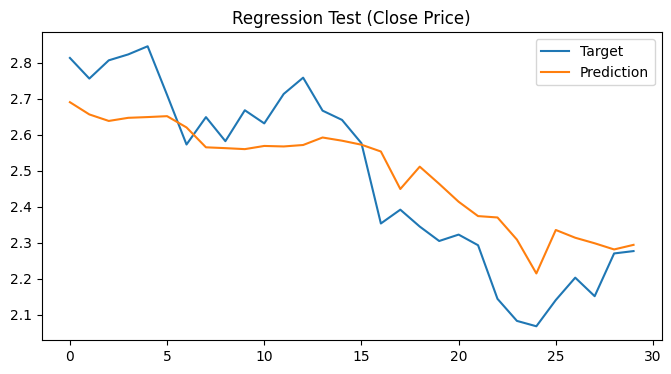

In [137]:
model_r.eval()
preds, targets = [], []

with torch.no_grad():
    for x, y in DataLoader(CryptoDataset(X_test_r, y_test_r), batch_size=1):
        preds.append(model_r(x.to(device)).item())
        targets.append(y.item())

plt.figure(figsize=(8,4))
plt.plot(targets, label="Target")
plt.plot(preds, label="Prediction")
plt.legend()
plt.title("Regression Test (Close Price)")
wandb.log({"regression_test_plot": wandb.Image(plt)})
plt.show()



In [138]:
X_c, y_c = make_sequence_data_cls(
    df, config.sequence_size, FEATURES_CLS,
    horizon=7, threshold=0.002
)


X_train_c = X_c[:-val_size-test_size]
X_test_c  = X_c[-test_size:]

y_train_c = y_c[:-val_size-test_size]
y_test_c  = y_c[-test_size:]


### Classification 학습 및 테스트

In [139]:
# 일관성을 위한 설정을 포함하여 DataLoader 생성
train_loader_c = DataLoader(
    CryptoDataset(X_train_c, y_train_c, classification=True),
    batch_size=config.batch_size,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)

test_loader_c = DataLoader(
    CryptoDataset(X_test_c, y_test_c, classification=True),
    batch_size=config.batch_size,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=0
)


model_c = TransformerClassification().to(device)


# ---------LSTM-----------
criterion_c = nn.CrossEntropyLoss()

optimizer_c = torch.optim.Adam(
    model_c.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4
)


for epoch in range(config.epochs_cls):
    model_c.train()
    train_loss = 0

    for x, y in train_loader_c:
        x, y = x.to(device), y.to(device)
        optimizer_c.zero_grad()
        loss = criterion_c(model_c(x), y)
        loss.backward()
        optimizer_c.step()
        train_loss += loss.item()

    train_loss /= len(train_loader_c)

    wandb.log({
        "cls_train_loss": train_loss,
        "epoch": epoch + 1
    })

    print(f"[Classification][Epoch {epoch+1}] Train Loss {train_loss:.6f}")


# Test Accuracy
model_c.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for x, y in test_loader_c:
        x = x.to(device)
        logits = model_c(x)
        # preds = torch.argmax(logits, dim=1).cpu().numpy()
        probs = torch.softmax(logits, dim=1)
        # preds = (probs[:, 1] > 0.5265).long().cpu().numpy()
        preds = (probs[:, 1] > 0.583).long().cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(y.cpu().numpy())

from sklearn.metrics import accuracy_score, f1_score

# Accuracy
acc = 100 * accuracy_score(y_true, y_pred)

# Macro F1 (상승 + 하락 동등 반영)
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

print(f"Classification Test Accuracy : {acc:.2f}%")
print(f"Classification Macro F1-score: {f1_macro:.4f}")

wandb.log({
    "classification_accuracy": acc,
    "classification_f1_macro": f1_macro
})


[Classification][Epoch 1] Train Loss 0.649090
[Classification][Epoch 2] Train Loss 0.631905
[Classification][Epoch 3] Train Loss 0.625480
[Classification][Epoch 4] Train Loss 0.627892
[Classification][Epoch 5] Train Loss 0.625654
[Classification][Epoch 6] Train Loss 0.630217
[Classification][Epoch 7] Train Loss 0.632260
[Classification][Epoch 8] Train Loss 0.641607
Classification Test Accuracy : 53.33%
Classification Macro F1-score: 0.4034


### 정답 <-> 에측 리스트

In [140]:
print("[TEST DATA]")
model_c.eval()

all_probs = []
all_preds = []
all_targets = []

THRESHOLD = 0.4884  # 네가 이미 튜닝한 threshold

with torch.no_grad():
    for x, y in test_loader_c:
        x = x.to(device)
        y = y.to(device)

        logits = model_c(x)
        probs = torch.softmax(logits, dim=1)[:, 1]   # class=1 확률
        preds = (probs > THRESHOLD).long()

        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(y)

# concat
all_probs = torch.cat(all_probs)
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

# Accuracy
correct = torch.sum(all_preds == all_targets).item()
acc = 100.0 * correct / len(all_targets)

print(f"TEST RESULTS (Accuracy): {acc:.3f}%")

# idx별 출력 (교수 의도 충족)
for idx, (prob, pred, target) in enumerate(
    zip(all_probs, all_preds, all_targets)
):
    print(
        f"{idx:2}: pred={pred.item()} "
        f"(p_up={prob.item():.3f}) <--> target={target.item()}"
    )


[TEST DATA]
TEST RESULTS (Accuracy): 13.333%
 0: pred=1 (p_up=0.579) <--> target=1
 1: pred=1 (p_up=0.578) <--> target=0
 2: pred=1 (p_up=0.578) <--> target=0
 3: pred=1 (p_up=0.577) <--> target=0
 4: pred=1 (p_up=0.576) <--> target=0
 5: pred=1 (p_up=0.576) <--> target=0
 6: pred=1 (p_up=0.576) <--> target=0
 7: pred=1 (p_up=0.578) <--> target=0
 8: pred=1 (p_up=0.579) <--> target=0
 9: pred=1 (p_up=0.578) <--> target=0
10: pred=1 (p_up=0.580) <--> target=0
11: pred=1 (p_up=0.579) <--> target=0
12: pred=1 (p_up=0.582) <--> target=1
13: pred=1 (p_up=0.584) <--> target=1
14: pred=1 (p_up=0.585) <--> target=0
15: pred=1 (p_up=0.583) <--> target=0
16: pred=1 (p_up=0.579) <--> target=0
17: pred=1 (p_up=0.586) <--> target=0
18: pred=1 (p_up=0.586) <--> target=0
19: pred=1 (p_up=0.586) <--> target=0
20: pred=1 (p_up=0.586) <--> target=0
21: pred=1 (p_up=0.586) <--> target=0
22: pred=1 (p_up=0.586) <--> target=0
23: pred=1 (p_up=0.586) <--> target=0
24: pred=1 (p_up=0.586) <--> target=0
25: p

In [142]:
wandb.finish()


classification_accuracy,▁
classification_f1_macro,▁
cls_train_loss,█▃▁▂▁▂▃▆
epoch,▁▂▂▃▄▄▅▅▆▇▇█▁▂▂▃▄▄▅▅
reg_train_loss,█▂▁▁▁▁▁▁▁▁▁▁
reg_val_loss,▂▄█▇▂▂▅▁▂▃▃▃
classification_accuracy,53.33333
classification_f1_macro,0.40341
cls_train_loss,0.64161
epoch,8
reg_train_loss,0.00354


### Optional 문제 고찰

self-attention을 사용하니 회귀와 분류 성능이 조금 떨어졌다.
이 이유에 대해서 생각을 해보았는데, 금융 시계열 데이터는 일반적으로 최근 시점의 정보가 가장 중요한 영향을 미치며 장기적인 전 구간 의존성보다는 단기적인 가격 흐름과 추세가 중요하다. LSTM은 이러한 특성을 반영하여 시간 순서에 따라 정보를 누적하고 최근 정보에 더 큰 가중치를 부여하는 구조를 가진다. 반면 self-attention은 모든 시점을 동일하게 고려하므로 불필요한 시점 간 관계까지 학습할 가능성이 있다. 이로 인해 금융 시계열과 같이 국소적 패턴이 중요한 데이터에서는 self-attention이 오히려 비효율적으로 작동할 수 있다고 생각한다. 또한 self-attention을 사용할때의 Next_Open피처의 추가는 미래 시점 정보를 포함하는 피처로써 모델 학습 시 유용한 정보로 작용할 수도 있지만 self-attention 과 같이 모든데이터의 관계가 복잡하게 얽히는 모델에서는 좋은 성능을 내지못하고 또한 데이터 수가 충분하지 않은 상황에서 추가된 피처는 성능 향상보다는 노이즈로 작용되었을 수도 있다 생각한다.

# 숙제 후기

이번 한 학기 동안 총 4개의 과제를 수행하면서 개인적으로 많은 것을 배우고 성장할 수 있었던 시간이었다고 생각합니다.
특히 이번 마지막 과제는 그중에서도 가장 난이도가 높았던 과제였습니다. 시계열 데이터를 다루는 것 자체가 익숙하지 않았고, 처음에는 어떻게 접근해야 할지 막막했지만, RNN, LSTM, 그리고 Self-Attention과 같은 다양한 시계열 모델 구조를 직접 구현하고 실험해 보면서 각 모델의 동작 원리와 특성을 이해할 수 있게 되었습니다.

수업을 듣기 전에는 Attention 기반 모델이 가장 최신 구조이기 때문에 항상 더 좋은 성능을 낼 것이라고 막연히 생각했지만, 실험을 진행하면서 데이터의 특성과 크기에 따라 LSTM과 Attention 모델이 각각 더 잘 맞는 상황이 다르다는 점을 체감할 수 있었습니다. 특히 데이터의 양이 충분하지 않은 상황에서는 Attention이 기대만큼의 성능을 발휘하지 못할 수 있다는 점을 이번 과제를 통해 직접 확인할 수 있었습니다.

또한 제공받은 기본 코드에서 출발하여 하이퍼파라미터 튜닝, threshold 조정, 평가 지표 변경 등을 직접 시도해 보면서 모델이 점점 개선되는 과정을 경험한 것이 매우 인상 깊었습니다. 단순히 결과를 확인하는 것을 넘어, 모델이 내 손을 거쳐 변화하는 과정을 관찰하는 것이 딥러닝 학습의 재미라는 것도 느낄 수 있었습니다. 이 경험을 통해 딥러닝과 시계열 모델에 대해 더 깊이 공부해 보고 싶다는 동기 역시 생기게 되었습니다.

평가 지표와 관련해서는 Accuracy만으로는 모델의 성능을 정확히 판단하기 어렵다고 느껴 Macro F1-score를 함께 사용하였습니다. 테스트 과정에서 모든 예측을 하나의 클래스(0)로만 출력하더라도 Accuracy가 80% 이상 나올 수 있다는 점을 확인하면서, 클래스 불균형이 존재하는 문제에서는 Macro F1-score가 더 적절한 평가 지표라는 점을 직접 체감할 수 있었습니다.

이번 과제를 포함한 한 학기 동안의 과제들을 통해 이론과 구현을 함께 경험할 수 있었고, 단순한 코드 작성이 아니라 모델의 특성과 한계를 고민하는 시각을 기를 수 있었던 것 같습니다. 한 학기 동안 많은 것을 가르쳐 주셔서 감사드리며, 과제를 준비하시고 지도해 주시느라 정말 고생 많으셨습니다. 감사합니다.

In [143]:
import json
import pandas as pd
from pathlib import Path

def load_history_from_run(run_dir: Path) -> pd.DataFrame:
    # run_dir 안에서 wandb-history.jsonl 자동 탐색
    history_files = list(run_dir.rglob("wandb-history.jsonl"))
    
    if len(history_files) == 0:
        raise FileNotFoundError(f"wandb-history.jsonl 없음: {run_dir}")
    
    hist_path = history_files[0]  # 보통 1개만 존재
    rows = []
    with open(hist_path, "r") as f:
        for line in f:
            rows.append(json.loads(line))
    
    return pd.DataFrame(rows)


In [144]:
df0 = load_history_from_run(recent8[0])
df0.head(), df0.columns


NameError: name 'recent8' is not defined